<a href="https://colab.research.google.com/github/aslla77/practice-Python/blob/main/2nd/21_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GRU
## LSTM과 비슷 하지만, 더 간단한 구조이다
- cell state가 없고 GRU 출력 H값이 그역활을 대신함
- Reset gate ,Update gate 2가지만 존재
  - sigmoid 2번 tanh 1번만 사용하여 연산이 줄어든다
  - LSTM은 활성화 함수가 5번 존재(sigmoid 3, tanh 2)




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU,Dense,Dropout

In [2]:
filename='/content/drive/MyDrive/005930.KS.csv'

#20년치 데이터 불러오기

raw_df=pd.read_csv(filename)

raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-08-12,6380.0,6420.0,6260.0,6340.0,4797.509766,38830000
1,2002-08-13,6340.0,6490.0,6340.0,6490.0,4911.016113,19635000
2,2002-08-14,6440.0,6460.0,6360.0,6440.0,4873.179199,35980000
3,2002-08-15,6440.0,6440.0,6440.0,6440.0,4873.179199,0
4,2002-08-16,6600.0,6660.0,6500.0,6510.0,4926.148926,31750000


In [3]:
#3일 평균이동선과 5일 평균이동선 생성
ma5 = raw_df['Adj Close'].rolling(window=5).mean()
ma3 = raw_df['Adj Close'].rolling(window=3).mean()

raw_df.insert(len(raw_df.columns), "3MA", ma3)
raw_df.insert(len(raw_df.columns), "5MA", ma5)
raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2002-08-12,6380.0,6420.0,6260.0,6340.0,4797.509766,38830000,NaN,NaN
1,2002-08-13,6340.0,6490.0,6340.0,6490.0,4911.016113,19635000,NaN,NaN
2,2002-08-14,6440.0,6460.0,6360.0,6440.0,4873.179199,35980000,4860.568359,NaN
3,2002-08-15,6440.0,6440.0,6440.0,6440.0,4873.179199,0,4885.791504,NaN
4,2002-08-16,6600.0,6660.0,6500.0,6510.0,4926.148926,31750000,4890.835775,4876.206641


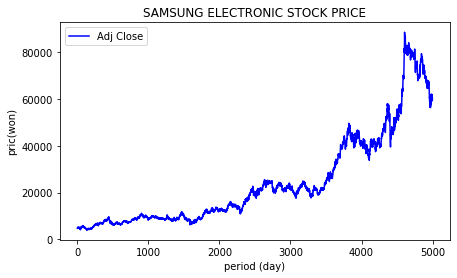

In [4]:
plt.figure(figsize=(7,4))

plt.title('SAMSUNG ELECTRONIC STOCK PRICE')
plt.ylabel('pric(won)')
plt.xlabel('period (day)')

plt.plot(raw_df['Adj Close'],label='Adj Close',color='b')
plt.legend(loc='best')
plt.show()
#LSTM 이용하여 20년간 의 주가 데이터 학습 그리고 예측

In [5]:
raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          2
5MA          4
dtype: int64

In [6]:
raw_df['Volume']=raw_df['Volume'].replace(0,np.nan)

raw_df=raw_df.dropna()
raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

In [7]:
#정규화
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()

scale_cols=['Open','High','Low','Close','Adj Close',
            '3MA','5MA','Volume']

scaled_df=scaler.fit_transform(raw_df[scale_cols])

print(type(scaled_df),'\n')

scaled_df= pd.DataFrame(scaled_df,columns=scale_cols)

print(scaled_df)

<class 'numpy.ndarray'> 

          Open      High       Low     Close  Adj Close       3MA       5MA  \
0     0.015062  0.013138  0.015538  0.013083   0.010055  0.009311  0.008929   
1     0.015533  0.013576  0.016368  0.014835   0.011401  0.009974  0.009511   
2     0.017416  0.016203  0.018740  0.017872   0.013736  0.011421  0.010292   
3     0.018828  0.016860  0.019689  0.018806   0.014454  0.012897  0.011311   
4     0.020240  0.017517  0.020638  0.018222   0.014005  0.013771  0.012238   
...        ...       ...       ...       ...        ...       ...       ...   
4918  0.659920  0.612437  0.657217  0.647237   0.672937  0.682808  0.687618   
4919  0.650506  0.604773  0.645356  0.637893   0.663446  0.676835  0.683533   
4920  0.630501  0.588351  0.633495  0.627380   0.652769  0.667278  0.678246   
4921  0.638739  0.597110  0.641798  0.636725   0.662260  0.663694  0.674401   
4922  0.637562  0.604773  0.642984  0.640229   0.665819  0.664490  0.671277   

        Volume  
0     0.

In [8]:
#입력 데이터와 정답 데이터 정의 후 numpyfh 변환하여 데이터 전처리 과정을 완료함

feature_cols=['3MA','5MA','Adj Close']# 입력 데이터
label_cols=['Adj Close'] #정답 데이터

label_df=pd.DataFrame(scaled_df,columns=label_cols)
feature_df=pd.DataFrame(scaled_df,columns=feature_cols)

print(feature_df)
print(label_df)

label_np=label_df.to_numpy()
feature_np=feature_df.to_numpy()

           3MA       5MA  Adj Close
0     0.009311  0.008929   0.010055
1     0.009974  0.009511   0.011401
2     0.011421  0.010292   0.013736
3     0.012897  0.011311   0.014454
4     0.013771  0.012238   0.014005
...        ...       ...        ...
4918  0.682808  0.687618   0.672937
4919  0.676835  0.683533   0.663446
4920  0.667278  0.678246   0.652769
4921  0.663694  0.674401   0.662260
4922  0.664490  0.671277   0.665819

[4923 rows x 3 columns]
      Adj Close
0      0.010055
1      0.011401
2      0.013736
3      0.014454
4      0.014005
...         ...
4918   0.672937
4919   0.663446
4920   0.652769
4921   0.662260
4922   0.665819

[4923 rows x 1 columns]


In [9]:
#딥러닝 과정
def make_sequene_dataset(feature,label,window_size): #입력 파라미터

  feature_list=[]
  label_list=[]

  for i in range(len(feature)-window_size):

    feature_list.append(feature[i:i+window_size])
    label_list.append(label[i+window_size])

  return np.array(feature_list),np.array(label_list)

window_size=40

X,Y=make_sequene_dataset(feature_np,label_np,window_size)

print(X.shape,Y.shape)

(4883, 40, 3) (4883, 1)


In [10]:
split=-200

x_train=X[0:split]
y_train=Y[0:split]

x_test=X[split:]
y_test=Y[split:]

model=Sequential()

model.add(GRU(256,
               activation='tanh',
               input_shape=x_train[0].shape))

model.add(Dense(1,activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               200448    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 200,705
Trainable params: 200,705
Non-trainable params: 0
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='mse',optimizer='adam',metrics=['mae'])

early_stop=EarlyStopping(monitor='val_loss',patience=5)

model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=16,callbacks=[early_stop])

Epoch 1/100
293/293 [==============================] - 13s 13ms/step - loss: 0.0011 - mae: 0.0124 - val_loss: 2.9813e-04 - val_mae: 0.0136
Epoch 2/100
293/293 [==============================] - 3s 9ms/step - loss: 8.2223e-05 - mae: 0.0059 - val_loss: 2.1937e-04 - val_mae: 0.0114
Epoch 3/100
293/293 [==============================] - 2s 8ms/step - loss: 8.0947e-05 - mae: 0.0058 - val_loss: 2.5130e-04 - val_mae: 0.0124
Epoch 4/100
293/293 [==============================] - 2s 6ms/step - loss: 7.6319e-05 - mae: 0.0057 - val_loss: 1.7757e-04 - val_mae: 0.0102
Epoch 5/100
293/293 [==============================] - 2s 5ms/step - loss: 8.0501e-05 - mae: 0.0060 - val_loss: 3.8327e-04 - val_mae: 0.0166
Epoch 6/100
293/293 [==============================] - 2s 6ms/step - loss: 7.0524e-05 - mae: 0.0055 - val_loss: 1.5357e-04 - val_mae: 0.0095
Epoch 7/100
293/293 [==============================] - 2s 5ms/step - loss: 5.7337e-05 - mae: 0.0050 - val_loss: 1.5548e-04 - val_mae: 0.0096
Epoch 8/100
293

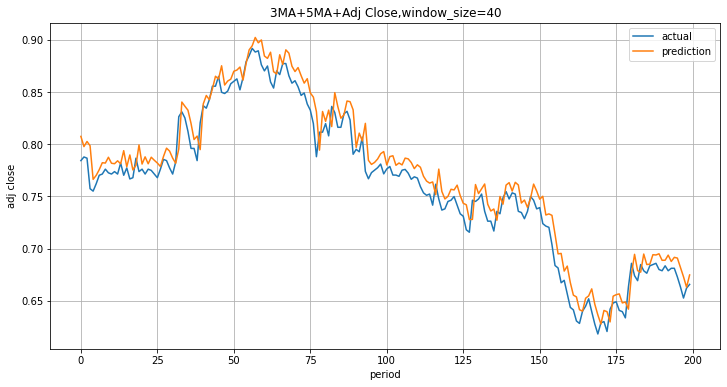

In [12]:
pred= model.predict(x_test)

plt.figure(figsize=(12,6))
plt.title('3MA+5MA+Adj Close,window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()